In [1]:
# pip install --upgrade scikit-learn

In [2]:
# I need to clarify certain things about this dataframe:
# The edges is actually based on the column "score"
# score column : Meaning
# 1 - 150 : Low confidence
# 150 - 450 : Medium confidence
# 450 - 1000 : High confidence

# The "mode" column just represents the type of edge
# Types of edges in mode column:
# reaction
# activation
# catalysis
# binding
# inhibition
# ptmod
# expression

In [3]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [4]:
# List of file names and corresponding DataFrame names
file_names = {
    "activation": "df_actions_27k_activation.csv",
    "binding": "df_actions_27k_binding.csv",
    "catalysis": "df_actions_27k_catalysis.csv",
    "expression": "df_actions_27k_expression.csv",
    "inhibition": "df_actions_27k_inhibition.csv",
    "ptmod": "df_actions_27k_ptmod.csv",
    "reaction": "df_actions_27k_reaction.csv",
    "combined" : "df_actions_27k.csv"
}

In [5]:
# Load CSV files into DataFrames
df_activation = pd.read_csv(file_names["activation"])
df_binding = pd.read_csv(file_names["binding"])
df_catalysis = pd.read_csv(file_names["catalysis"])
df_expression = pd.read_csv(file_names["expression"])
df_inhibition = pd.read_csv(file_names["inhibition"])
df_ptmod = pd.read_csv(file_names["ptmod"])
df_reaction = pd.read_csv(file_names["reaction"])
df_combined = pd.read_csv(file_names["combined"])

In [6]:
df_activation.head()

,sequence_a,sequence_b,item_id_a,item_id_b,mode,is_directional,a_is_acting,score
0,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MTECFLPPTSSPSEHRRVEHGSGLTRTPSSEEISPTKFPGLYRTGE...,9606.ENSP00000000233,9606.ENSP00000019317,activation,f,f,175
1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MTLESMMACCLSDEVKESKRINAEIEKQLRRDKRDARRELKLLLLG...,9606.ENSP00000000233,9606.ENSP00000078429,activation,f,f,152
2,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MFSRRSHGDVKKSTQKVLDPKKDVLTRLKHLRALLDNVDANDLKQF...,9606.ENSP00000000233,9606.ENSP00000202677,activation,f,f,153
3,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSLIRKKGFYKQDVNKTAWELPKTYVSPTHVGSGAYGSVCSAIDKR...,9606.ENSP00000000233,9606.ENSP00000211287,activation,f,f,157
4,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSSPPPARSGFYRQEVTKTAWEVRAVYRDLQPVGSGAYGAVCSAVD...,9606.ENSP00000000233,9606.ENSP00000215659,activation,f,f,157


In [7]:
df_activation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sequence_a      4500 non-null   object
 1   sequence_b      4500 non-null   object
 2   item_id_a       4500 non-null   object
 3   item_id_b       4500 non-null   object
 4   mode            4500 non-null   object
 5   is_directional  4500 non-null   object
 6   a_is_acting     4500 non-null   object
 7   score           4500 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 281.4+ KB


In [8]:
### Define GCN Model

class GCNLinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNLinkPrediction, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return z

In [9]:
def process_dataframe(df, mode_name):
    print(f"Processing {mode_name} dataset...")
    
    # Step 1: Create the graph
    protein_ids = pd.concat([df['item_id_a'], df['item_id_b']]).unique()
    protein_to_idx = {protein: idx for idx, protein in enumerate(protein_ids)}
    
    edge_index = np.array([
        [protein_to_idx[protein] for protein in df['item_id_a']],
        [protein_to_idx[protein] for protein in df['item_id_b']]
    ])
    
    edge_weights = df['score'].values
    
    # Step 2: Create node features (one-hot encoding of sequences)
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    encoder = OneHotEncoder(categories=[amino_acids], sparse_output=False)
    
    node_features = []
    for protein in protein_ids:
        sequence_a = df[df['item_id_a'] == protein]['sequence_a']
        sequence_b = df[df['item_id_b'] == protein]['sequence_b']
        
        if len(sequence_a) > 0:
            sequence = sequence_a.values[0]
        elif len(sequence_b) > 0:
            sequence = sequence_b.values[0]
        else:
            raise ValueError(f"Protein {protein} not found in either 'item_id_a' or 'item_id_b'.")
        
        encoded_seq = encoder.fit_transform(np.array(list(sequence)).reshape(-1, 1))
        node_features.append(encoded_seq.mean(axis=0))
    
    node_features_array = np.array(node_features)
    
    # Create PyG Data object
    data = Data(
        x=torch.tensor(node_features_array, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        edge_attr=torch.tensor(edge_weights, dtype=torch.float)  # Optional
    )
    
    # Step 3: Split the data
    edge_index = data.edge_index.numpy()
    edge_index_train, edge_index_test = train_test_split(edge_index.T, test_size=0.2, random_state=42)
    edge_index_train, edge_index_val = train_test_split(edge_index_train, test_size=0.1, random_state=42)
    
    edge_index_train = torch.tensor(edge_index_train, dtype=torch.long).t()
    edge_index_val = torch.tensor(edge_index_val, dtype=torch.long).t()
    edge_index_test = torch.tensor(edge_index_test, dtype=torch.long).t()
    
    # Step 4: Generate negative samples
    neg_edge_index_train = negative_sampling(edge_index_train, num_nodes=data.num_nodes)
    neg_edge_index_val = negative_sampling(edge_index_val, num_nodes=data.num_nodes)
    neg_edge_index_test = negative_sampling(edge_index_test, num_nodes=data.num_nodes)
    
    # Step 5: Train the model
    model = GCNLinkPrediction(in_channels=data.num_features, hidden_channels=16, out_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    def train():
        model.train()
        optimizer.zero_grad()
        
        pos_edge_index = edge_index_train
        neg_edge_index = neg_edge_index_train
        
        z = model(data.x, pos_edge_index)
        pos_score = model.decode(z, pos_edge_index)
        neg_score = model.decode(z, neg_edge_index)
        
        pos_loss = F.binary_cross_entropy_with_logits(pos_score, torch.ones(pos_score.size(0)))
        neg_loss = F.binary_cross_entropy_with_logits(neg_score, torch.zeros(neg_score.size(0)))
        loss = pos_loss + neg_loss
        
        loss.backward()
        optimizer.step()
        
        return loss.item()
    
    for epoch in range(1, 201):
        loss = train()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    # Step 6: Evaluate the model
    def evaluate(edge_index, neg_edge_index):
        model.eval()
        with torch.no_grad():
            z = model(data.x, edge_index)
            pos_score = model.decode(z, edge_index).sigmoid().cpu().numpy()
            neg_score = model.decode(z, neg_edge_index).sigmoid().cpu().numpy()
            
            y_true = np.hstack([np.ones(pos_score.size), np.zeros(neg_score.size)])
            y_score = np.hstack([pos_score, neg_score])
            
            auc_roc = roc_auc_score(y_true, y_score)
            auc_pr = average_precision_score(y_true, y_score)
            
            return auc_roc, auc_pr
    
    val_auc_roc, val_auc_pr = evaluate(edge_index_val, neg_edge_index_val)
    test_auc_roc, test_auc_pr = evaluate(edge_index_test, neg_edge_index_test)
    
    print(f"{mode_name} - Validation AUC-ROC: {val_auc_roc:.4f}, Validation AUC-PR: {val_auc_pr:.4f}")
    print(f"{mode_name} - Test AUC-ROC: {test_auc_roc:.4f}, Test AUC-PR: {test_auc_pr:.4f}")
    
    # Step 7: Save the model
    torch.save(model.state_dict(), f"gcn_link_prediction_{mode_name}.pth")
    
    # Step 8: Visualize node embeddings
    z = model.encode(data.x, data.edge_index).detach().cpu().numpy()
    tsne = TSNE(n_components=2, random_state=42)
    z_2d = tsne.fit_transform(z)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(z_2d[:, 0], z_2d[:, 1], s=10)
    plt.title(f"t-SNE Visualization of Node Embeddings ({mode_name})")
    plt.savefig(f"node_embeddings_{mode_name}.png")
    plt.show()
    
    # Return results
    return {
        "model": model,
        "val_auc_roc": val_auc_roc,
        "val_auc_pr": val_auc_pr,
        "test_auc_roc": test_auc_roc,
        "test_auc_pr": test_auc_pr,
        "node_embeddings": z,
        "tsne_embeddings": z_2d
    }


Processing activation mode...
Processing activation dataset...
Epoch: 001, Loss: 1.3781
Epoch: 002, Loss: 1.3689
Epoch: 003, Loss: 1.3602
Epoch: 004, Loss: 1.3580
Epoch: 005, Loss: 1.3602
Epoch: 006, Loss: 1.3564
Epoch: 007, Loss: 1.3519
Epoch: 008, Loss: 1.3501
Epoch: 009, Loss: 1.3496
Epoch: 010, Loss: 1.3488
Epoch: 011, Loss: 1.3469
Epoch: 012, Loss: 1.3442
Epoch: 013, Loss: 1.3414
Epoch: 014, Loss: 1.3393
Epoch: 015, Loss: 1.3381
Epoch: 016, Loss: 1.3365
Epoch: 017, Loss: 1.3343
Epoch: 018, Loss: 1.3320
Epoch: 019, Loss: 1.3299
Epoch: 020, Loss: 1.3282
Epoch: 021, Loss: 1.3261
Epoch: 022, Loss: 1.3241
Epoch: 023, Loss: 1.3222
Epoch: 024, Loss: 1.3205
Epoch: 025, Loss: 1.3188
Epoch: 026, Loss: 1.3166
Epoch: 027, Loss: 1.3143
Epoch: 028, Loss: 1.3125
Epoch: 029, Loss: 1.3110
Epoch: 030, Loss: 1.3090
Epoch: 031, Loss: 1.3070
Epoch: 032, Loss: 1.3054
Epoch: 033, Loss: 1.3035
Epoch: 034, Loss: 1.3017
Epoch: 035, Loss: 1.3000
Epoch: 036, Loss: 1.2985
Epoch: 037, Loss: 1.2966
Epoch: 038,

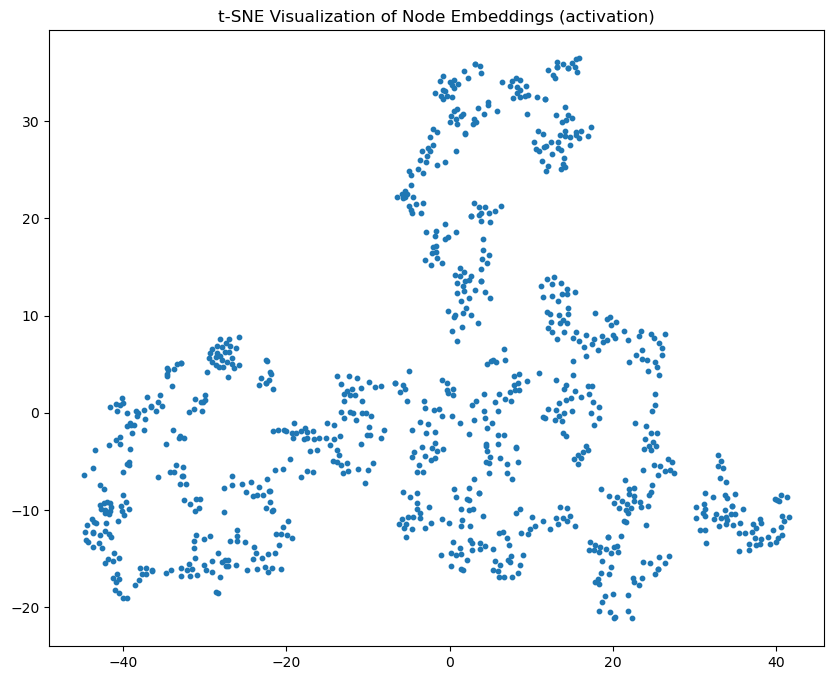


Processing binding mode...
Processing binding dataset...
Epoch: 001, Loss: 1.3853
Epoch: 002, Loss: 1.3847
Epoch: 003, Loss: 1.3841
Epoch: 004, Loss: 1.3837
Epoch: 005, Loss: 1.3832
Epoch: 006, Loss: 1.3827
Epoch: 007, Loss: 1.3822
Epoch: 008, Loss: 1.3815
Epoch: 009, Loss: 1.3809
Epoch: 010, Loss: 1.3800
Epoch: 011, Loss: 1.3791
Epoch: 012, Loss: 1.3782
Epoch: 013, Loss: 1.3770
Epoch: 014, Loss: 1.3757
Epoch: 015, Loss: 1.3742
Epoch: 016, Loss: 1.3726
Epoch: 017, Loss: 1.3707
Epoch: 018, Loss: 1.3686
Epoch: 019, Loss: 1.3662
Epoch: 020, Loss: 1.3635
Epoch: 021, Loss: 1.3606
Epoch: 022, Loss: 1.3573
Epoch: 023, Loss: 1.3537
Epoch: 024, Loss: 1.3498
Epoch: 025, Loss: 1.3456
Epoch: 026, Loss: 1.3411
Epoch: 027, Loss: 1.3366
Epoch: 028, Loss: 1.3320
Epoch: 029, Loss: 1.3274
Epoch: 030, Loss: 1.3230
Epoch: 031, Loss: 1.3189
Epoch: 032, Loss: 1.3152
Epoch: 033, Loss: 1.3122
Epoch: 034, Loss: 1.3101
Epoch: 035, Loss: 1.3089
Epoch: 036, Loss: 1.3063
Epoch: 037, Loss: 1.3050
Epoch: 038, Loss:

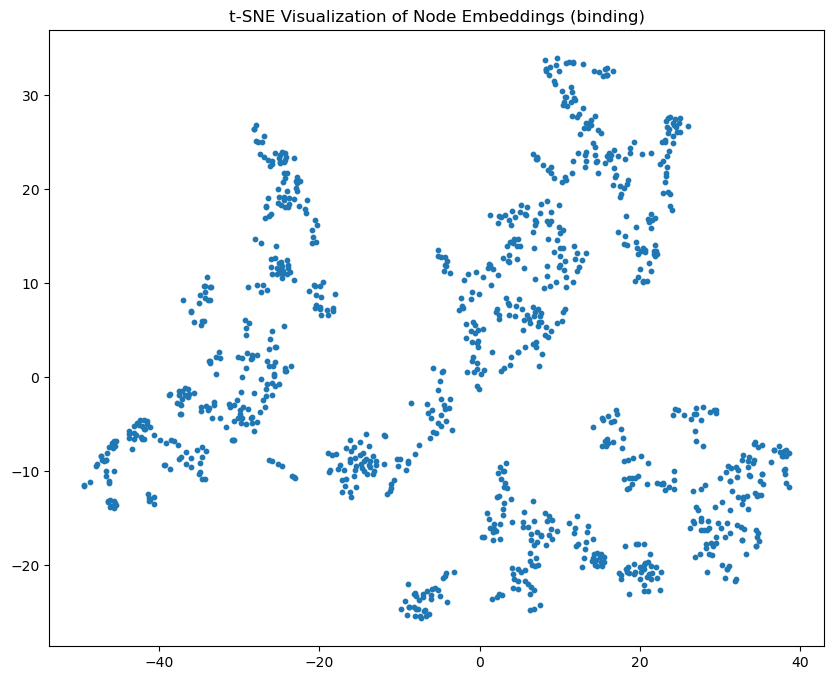


Processing catalysis mode...
Processing catalysis dataset...
Epoch: 001, Loss: 1.3848
Epoch: 002, Loss: 1.3835
Epoch: 003, Loss: 1.3830
Epoch: 004, Loss: 1.3824
Epoch: 005, Loss: 1.3818
Epoch: 006, Loss: 1.3810
Epoch: 007, Loss: 1.3802
Epoch: 008, Loss: 1.3794
Epoch: 009, Loss: 1.3787
Epoch: 010, Loss: 1.3779
Epoch: 011, Loss: 1.3771
Epoch: 012, Loss: 1.3763
Epoch: 013, Loss: 1.3754
Epoch: 014, Loss: 1.3745
Epoch: 015, Loss: 1.3737
Epoch: 016, Loss: 1.3726
Epoch: 017, Loss: 1.3717
Epoch: 018, Loss: 1.3706
Epoch: 019, Loss: 1.3696
Epoch: 020, Loss: 1.3684
Epoch: 021, Loss: 1.3673
Epoch: 022, Loss: 1.3662
Epoch: 023, Loss: 1.3649
Epoch: 024, Loss: 1.3635
Epoch: 025, Loss: 1.3622
Epoch: 026, Loss: 1.3605
Epoch: 027, Loss: 1.3589
Epoch: 028, Loss: 1.3572
Epoch: 029, Loss: 1.3551
Epoch: 030, Loss: 1.3530
Epoch: 031, Loss: 1.3508
Epoch: 032, Loss: 1.3482
Epoch: 033, Loss: 1.3456
Epoch: 034, Loss: 1.3427
Epoch: 035, Loss: 1.3394
Epoch: 036, Loss: 1.3360
Epoch: 037, Loss: 1.3322
Epoch: 038, L

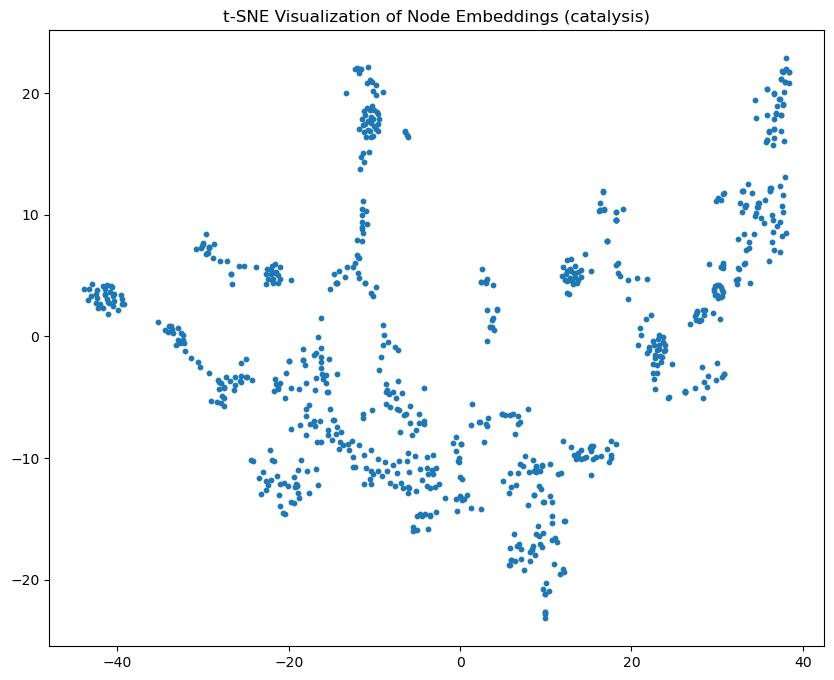


Processing expression mode...
Processing expression dataset...
Epoch: 001, Loss: 1.3608
Epoch: 002, Loss: 1.3451
Epoch: 003, Loss: 1.3274
Epoch: 004, Loss: 1.3127
Epoch: 005, Loss: 1.3073
Epoch: 006, Loss: 1.3113
Epoch: 007, Loss: 1.3100
Epoch: 008, Loss: 1.3024
Epoch: 009, Loss: 1.2950
Epoch: 010, Loss: 1.2909
Epoch: 011, Loss: 1.2893
Epoch: 012, Loss: 1.2882
Epoch: 013, Loss: 1.2864
Epoch: 014, Loss: 1.2834
Epoch: 015, Loss: 1.2794
Epoch: 016, Loss: 1.2752
Epoch: 017, Loss: 1.2717
Epoch: 018, Loss: 1.2693
Epoch: 019, Loss: 1.2678
Epoch: 020, Loss: 1.2659
Epoch: 021, Loss: 1.2630
Epoch: 022, Loss: 1.2596
Epoch: 023, Loss: 1.2567
Epoch: 024, Loss: 1.2546
Epoch: 025, Loss: 1.2531
Epoch: 026, Loss: 1.2514
Epoch: 027, Loss: 1.2492
Epoch: 028, Loss: 1.2469
Epoch: 029, Loss: 1.2450
Epoch: 030, Loss: 1.2437
Epoch: 031, Loss: 1.2426
Epoch: 032, Loss: 1.2411
Epoch: 033, Loss: 1.2394
Epoch: 034, Loss: 1.2379
Epoch: 035, Loss: 1.2370
Epoch: 036, Loss: 1.2362
Epoch: 037, Loss: 1.2351
Epoch: 038,

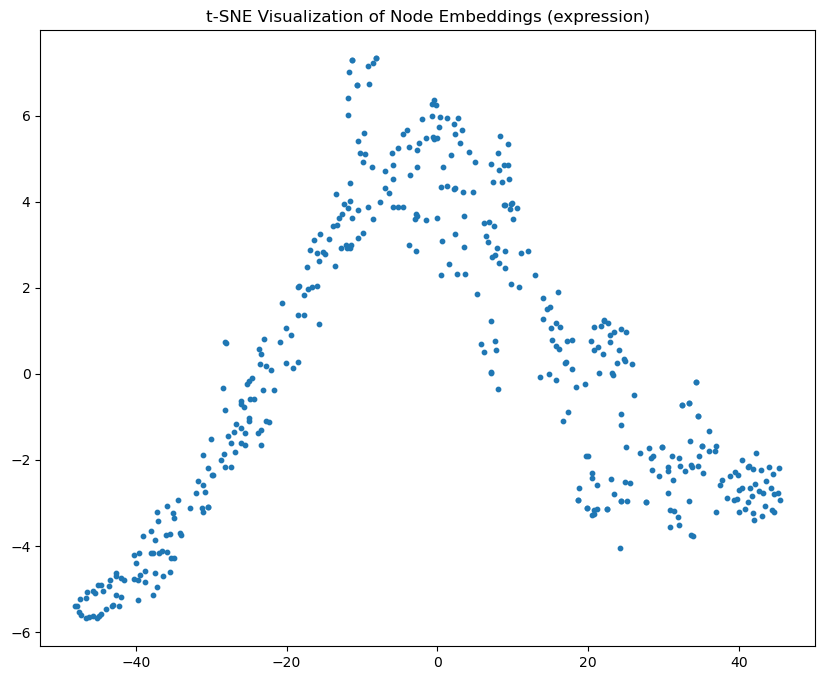


Processing inhibition mode...
Processing inhibition dataset...
Epoch: 001, Loss: 1.3822
Epoch: 002, Loss: 1.3750
Epoch: 003, Loss: 1.3672
Epoch: 004, Loss: 1.3649
Epoch: 005, Loss: 1.3660
Epoch: 006, Loss: 1.3615
Epoch: 007, Loss: 1.3575
Epoch: 008, Loss: 1.3560
Epoch: 009, Loss: 1.3550
Epoch: 010, Loss: 1.3529
Epoch: 011, Loss: 1.3499
Epoch: 012, Loss: 1.3469
Epoch: 013, Loss: 1.3450
Epoch: 014, Loss: 1.3439
Epoch: 015, Loss: 1.3419
Epoch: 016, Loss: 1.3389
Epoch: 017, Loss: 1.3368
Epoch: 018, Loss: 1.3357
Epoch: 019, Loss: 1.3338
Epoch: 020, Loss: 1.3312
Epoch: 021, Loss: 1.3293
Epoch: 022, Loss: 1.3283
Epoch: 023, Loss: 1.3263
Epoch: 024, Loss: 1.3240
Epoch: 025, Loss: 1.3228
Epoch: 026, Loss: 1.3212
Epoch: 027, Loss: 1.3188
Epoch: 028, Loss: 1.3172
Epoch: 029, Loss: 1.3158
Epoch: 030, Loss: 1.3133
Epoch: 031, Loss: 1.3117
Epoch: 032, Loss: 1.3101
Epoch: 033, Loss: 1.3077
Epoch: 034, Loss: 1.3055
Epoch: 035, Loss: 1.3035
Epoch: 036, Loss: 1.3008
Epoch: 037, Loss: 1.2987
Epoch: 038,

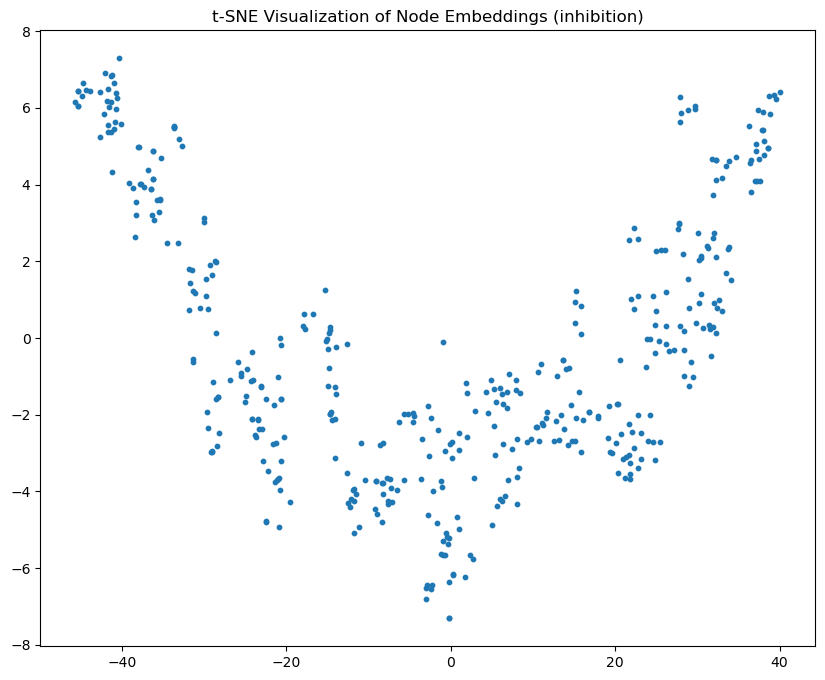


Processing ptmod mode...
Processing ptmod dataset...
Epoch: 001, Loss: 1.3779
Epoch: 002, Loss: 1.3657
Epoch: 003, Loss: 1.3523
Epoch: 004, Loss: 1.3409
Epoch: 005, Loss: 1.3360
Epoch: 006, Loss: 1.3371
Epoch: 007, Loss: 1.3363
Epoch: 008, Loss: 1.3298
Epoch: 009, Loss: 1.3231
Epoch: 010, Loss: 1.3195
Epoch: 011, Loss: 1.3178
Epoch: 012, Loss: 1.3159
Epoch: 013, Loss: 1.3133
Epoch: 014, Loss: 1.3098
Epoch: 015, Loss: 1.3059
Epoch: 016, Loss: 1.3024
Epoch: 017, Loss: 1.3001
Epoch: 018, Loss: 1.2987
Epoch: 019, Loss: 1.2968
Epoch: 020, Loss: 1.2938
Epoch: 021, Loss: 1.2909
Epoch: 022, Loss: 1.2889
Epoch: 023, Loss: 1.2876
Epoch: 024, Loss: 1.2857
Epoch: 025, Loss: 1.2832
Epoch: 026, Loss: 1.2814
Epoch: 027, Loss: 1.2803
Epoch: 028, Loss: 1.2787
Epoch: 029, Loss: 1.2765
Epoch: 030, Loss: 1.2750
Epoch: 031, Loss: 1.2740
Epoch: 032, Loss: 1.2724
Epoch: 033, Loss: 1.2707
Epoch: 034, Loss: 1.2693
Epoch: 035, Loss: 1.2680
Epoch: 036, Loss: 1.2665
Epoch: 037, Loss: 1.2651
Epoch: 038, Loss: 1.2

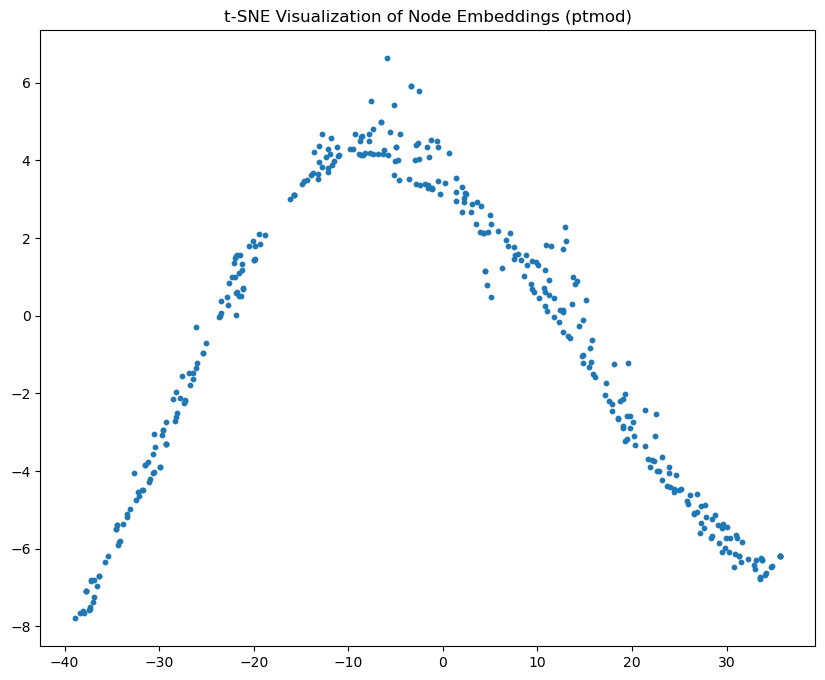


Processing reaction mode...
Processing reaction dataset...
Epoch: 001, Loss: 1.3862
Epoch: 002, Loss: 1.3856
Epoch: 003, Loss: 1.3851
Epoch: 004, Loss: 1.3850
Epoch: 005, Loss: 1.3848
Epoch: 006, Loss: 1.3845
Epoch: 007, Loss: 1.3842
Epoch: 008, Loss: 1.3839
Epoch: 009, Loss: 1.3835
Epoch: 010, Loss: 1.3830
Epoch: 011, Loss: 1.3826
Epoch: 012, Loss: 1.3821
Epoch: 013, Loss: 1.3815
Epoch: 014, Loss: 1.3808
Epoch: 015, Loss: 1.3802
Epoch: 016, Loss: 1.3795
Epoch: 017, Loss: 1.3786
Epoch: 018, Loss: 1.3776
Epoch: 019, Loss: 1.3765
Epoch: 020, Loss: 1.3753
Epoch: 021, Loss: 1.3741
Epoch: 022, Loss: 1.3726
Epoch: 023, Loss: 1.3709
Epoch: 024, Loss: 1.3691
Epoch: 025, Loss: 1.3672
Epoch: 026, Loss: 1.3650
Epoch: 027, Loss: 1.3626
Epoch: 028, Loss: 1.3601
Epoch: 029, Loss: 1.3573
Epoch: 030, Loss: 1.3543
Epoch: 031, Loss: 1.3511
Epoch: 032, Loss: 1.3477
Epoch: 033, Loss: 1.3441
Epoch: 034, Loss: 1.3406
Epoch: 035, Loss: 1.3373
Epoch: 036, Loss: 1.3334
Epoch: 037, Loss: 1.3300
Epoch: 038, Los

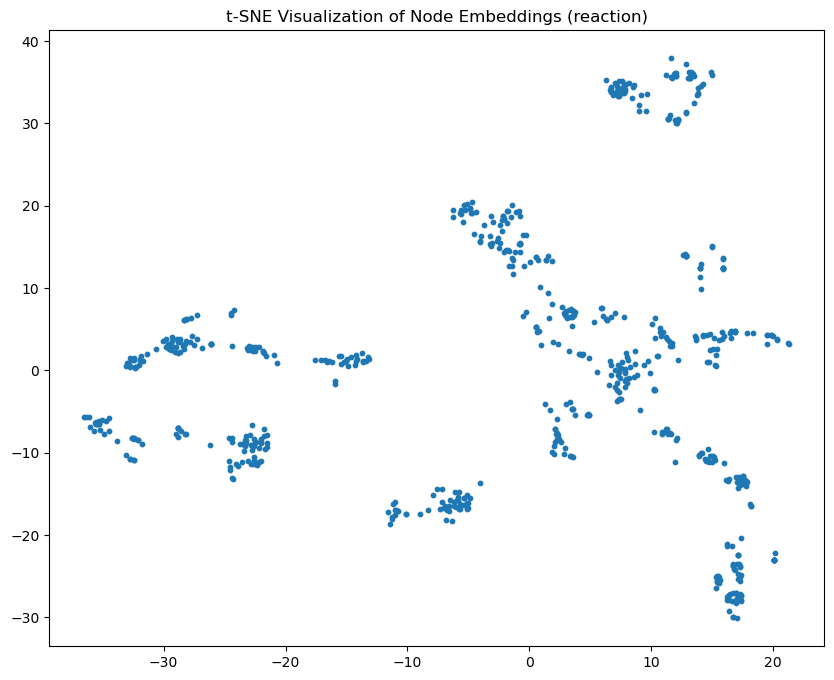


Processing combined mode...
Processing combined dataset...
Epoch: 001, Loss: 1.3732
Epoch: 002, Loss: 1.3622
Epoch: 003, Loss: 1.3515
Epoch: 004, Loss: 1.3469
Epoch: 005, Loss: 1.3478
Epoch: 006, Loss: 1.3455
Epoch: 007, Loss: 1.3401
Epoch: 008, Loss: 1.3383
Epoch: 009, Loss: 1.3372
Epoch: 010, Loss: 1.3343
Epoch: 011, Loss: 1.3302
Epoch: 012, Loss: 1.3271
Epoch: 013, Loss: 1.3252
Epoch: 014, Loss: 1.3231
Epoch: 015, Loss: 1.3201
Epoch: 016, Loss: 1.3172
Epoch: 017, Loss: 1.3151
Epoch: 018, Loss: 1.3130
Epoch: 019, Loss: 1.3106
Epoch: 020, Loss: 1.3082
Epoch: 021, Loss: 1.3060
Epoch: 022, Loss: 1.3039
Epoch: 023, Loss: 1.3015
Epoch: 024, Loss: 1.2993
Epoch: 025, Loss: 1.2978
Epoch: 026, Loss: 1.2960
Epoch: 027, Loss: 1.2939
Epoch: 028, Loss: 1.2924
Epoch: 029, Loss: 1.2907
Epoch: 030, Loss: 1.2885
Epoch: 031, Loss: 1.2870
Epoch: 032, Loss: 1.2854
Epoch: 033, Loss: 1.2837
Epoch: 034, Loss: 1.2825
Epoch: 035, Loss: 1.2808
Epoch: 036, Loss: 1.2793
Epoch: 037, Loss: 1.2780
Epoch: 038, Los

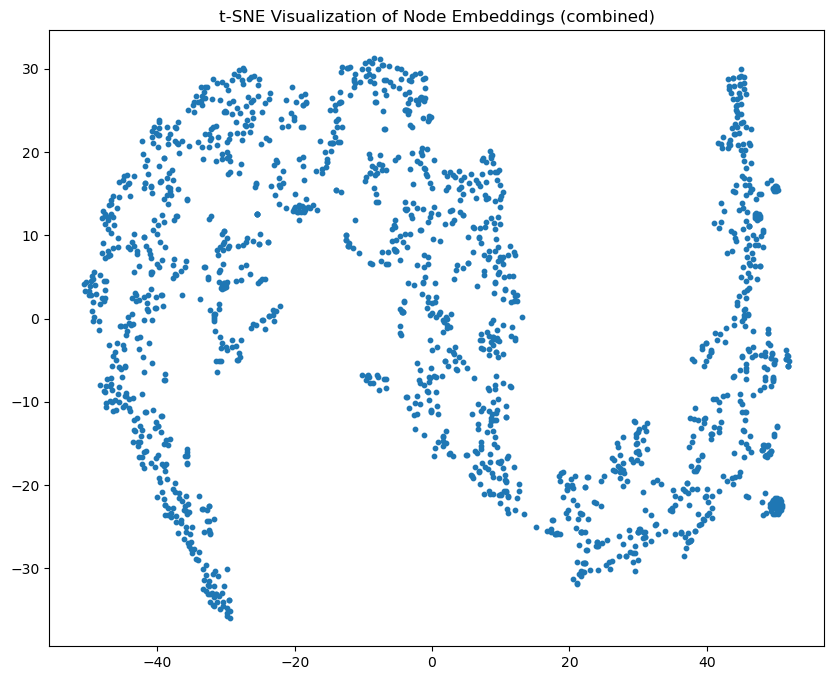

In [10]:
# Process each dataframe and store results
results = {}

dataframes = {
    "activation": df_activation,
    "binding": df_binding,
    "catalysis": df_catalysis,
    "expression": df_expression,
    "inhibition": df_inhibition,
    "ptmod": df_ptmod,
    "reaction": df_reaction,
    "combined": df_combined
}

for mode_name, df in dataframes.items():
    print(f"\nProcessing {mode_name} mode...")
    results[mode_name] = process_dataframe(df, mode_name)

In [11]:
# Print results for all modes
for mode_name, result in results.items():
    print(f"\n{mode_name.capitalize()} Mode Results:")
    print(f"Validation AUC-ROC: {result['val_auc_roc']:.4f}")
    print(f"Validation AUC-PR: {result['val_auc_pr']:.4f}")
    print(f"Test AUC-ROC: {result['test_auc_roc']:.4f}")
    print(f"Test AUC-PR: {result['test_auc_pr']:.4f}")


Activation Mode Results:
Validation AUC-ROC: 0.8342
Validation AUC-PR: 0.8245
Test AUC-ROC: 0.8254
Test AUC-PR: 0.8231

Binding Mode Results:
Validation AUC-ROC: 0.8301
Validation AUC-PR: 0.7894
Test AUC-ROC: 0.8158
Test AUC-PR: 0.8035

Catalysis Mode Results:
Validation AUC-ROC: 0.8097
Validation AUC-PR: 0.7990
Test AUC-ROC: 0.7960
Test AUC-PR: 0.7837

Expression Mode Results:
Validation AUC-ROC: 0.7552
Validation AUC-PR: 0.8020
Test AUC-ROC: 0.7228
Test AUC-PR: 0.7938

Inhibition Mode Results:
Validation AUC-ROC: 0.8232
Validation AUC-PR: 0.8021
Test AUC-ROC: 0.8173
Test AUC-PR: 0.7933

Ptmod Mode Results:
Validation AUC-ROC: 0.7840
Validation AUC-PR: 0.7524
Test AUC-ROC: 0.8020
Test AUC-PR: 0.8107

Reaction Mode Results:
Validation AUC-ROC: 0.8249
Validation AUC-PR: 0.7999
Test AUC-ROC: 0.8426
Test AUC-PR: 0.8328

Combined Mode Results:
Validation AUC-ROC: 0.7887
Validation AUC-PR: 0.7768
Test AUC-ROC: 0.8091
Test AUC-PR: 0.8133
